In [2]:
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense, Dropout
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.preprocessing import StandardScaler
import seaborn as sns

In [3]:
df = pd.read_csv('E:\Projects\Automated_Hyperparameter_Tuning-Time-Series-LSTM\seattle-weather.csv')
df_tempmax1 = df["temp_max"]
df_tempmin = df["temp_min"]
df_wind = df["wind"]
df_weather = df["weather"]
print(df.head())

         date  precipitation  temp_max  temp_min  wind  weather
0  2012-01-01            0.0      12.8       5.0   4.7  drizzle
1  2012-01-02           10.9      10.6       2.8   4.5     rain
2  2012-01-03            0.8      11.7       7.2   2.3     rain
3  2012-01-04           20.3      12.2       5.6   4.7     rain
4  2012-01-05            1.3       8.9       2.8   6.1     rain


<Axes: ylabel='temp_max'>

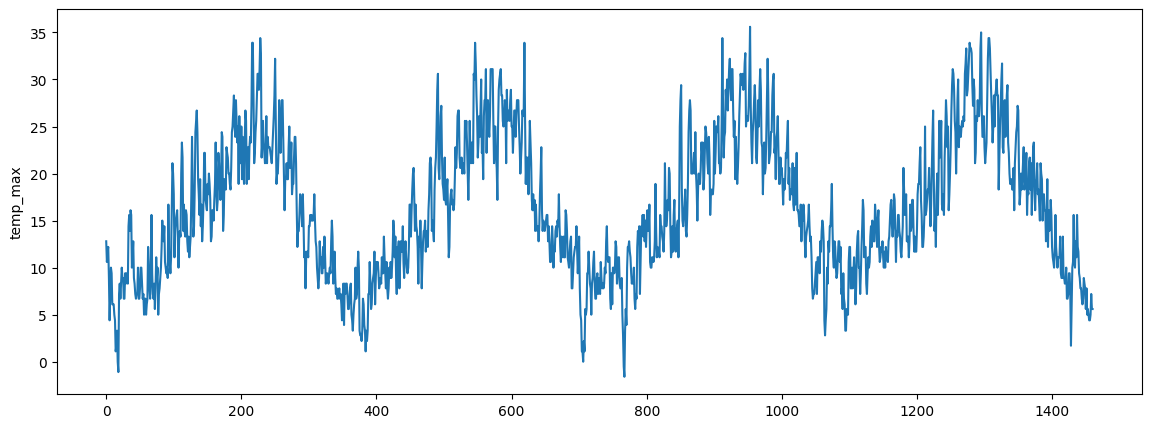

In [4]:
plt.figure(figsize=(14,5))
sns.lineplot(df_tempmax1)

In [6]:
def df_to_XY(df,window_size=10):
    df_np = df_tempmax1.to_numpy()
    X = []
    y = []
    for i in range(len(df_np)-window_size):
        row = [[a] for a in df_np[i:i+window_size]]
        X.append(row)
        target = df_np[i+window_size]
        y.append(target)
    return np.array(X),np.array(y)

In [7]:
WINDOW = 10
X,y = df_to_XY(df,WINDOW)
print(len(X),len(y))
X_train = X[:800]
y_train = y[:800]
X_val = X[800:1000]
y_val = y[800:1000]
X_test = X[1000:]
y_test = y[1000:]

1451 1451


In [8]:
X.shape

(1451, 10, 1)

In [9]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import r2_score

In [10]:
model = Sequential()
model.add(LSTM(64,input_shape=(WINDOW,1),activation = "relu"))
model.add(Dense(32,activation="relu"))
model.add(Dropout(0.2))
model.add(Dense(16,"relu"))
model.add(Dense(1,"linear"))
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 64)                16896     
                                                                 
 dense (Dense)               (None, 32)                2080      
                                                                 
 dropout (Dropout)           (None, 32)                0         
                                                                 
 dense_1 (Dense)             (None, 16)                528       
                                                                 
 dense_2 (Dense)             (None, 1)                 17        
                                                                 
Total params: 19521 (76.25 KB)
Trainable params: 19521 (76.25 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [11]:
callback1 = ModelCheckpoint('model/',save_best_only=True)
earlyStopping = EarlyStopping(monitor="val_root_mean_squared_error",patience=3,start_from_epoch=5,restore_best_weights=True,)
model.compile(loss=MeanSquaredError(),optimizer=Adam(learning_rate=0.0001),metrics=RootMeanSquaredError())

In [12]:
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=100)

Epoch 1/100

25/25 [==============================] - 2s 23ms/step - loss: 264.8104 - root_mean_squared_error: 16.2730 - val_loss: 475.9226 - val_root_mean_squared_error: 21.8156
Epoch 2/100
25/25 [==============================] - 0s 9ms/step - loss: 233.3576 - root_mean_squared_error: 15.2760 - val_loss: 390.1935 - val_root_mean_squared_error: 19.7533
Epoch 3/100
25/25 [==============================] - 0s 9ms/step - loss: 180.5860 - root_mean_squared_error: 13.4382 - val_loss: 233.5952 - val_root_mean_squared_error: 15.2838
Epoch 4/100
25/25 [==============================] - 0s 10ms/step - loss: 83.6445 - root_mean_squared_error: 9.1457 - val_loss: 33.8159 - val_root_mean_squared_error: 5.8151
Epoch 5/100
25/25 [==============================] - 0s 9ms/step - loss: 30.1234 - root_mean_squared_error: 5.4885 - val_loss: 20.0067 - val_root_mean_squared_error: 4.4729
Epoch 6/100
25/25 [==============================] - 0s 9ms/step - loss: 23.7140 - root_mean_squared_error: 4.8697 - val

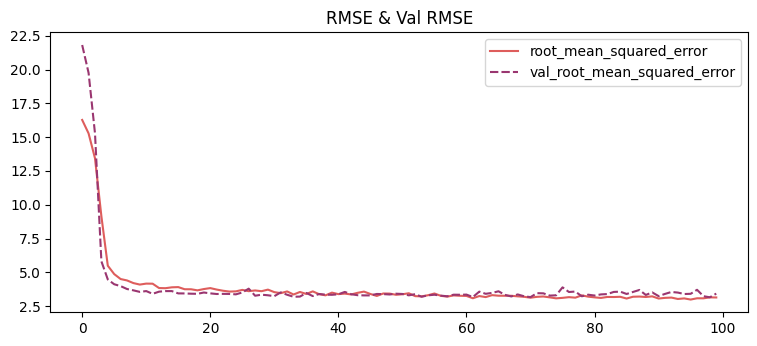

In [13]:
his = pd.DataFrame(history.history)
his.columns
history_rmse =  his[['root_mean_squared_error', 'val_root_mean_squared_error']]

plt.figure(figsize=(9,8))
plt.subplot(2,1,2)
plt.title("RMSE & Val RMSE")
sns.lineplot(history_rmse,palette="flare");

In [14]:
train_pred = model.predict(X_train).flatten()
val_pred = model.predict(X_val).flatten()
test_pred = model.predict(X_test).flatten()

15/15 [==============================] - 0s 4ms/step


<Axes: title={'center': 'Test Results'}>

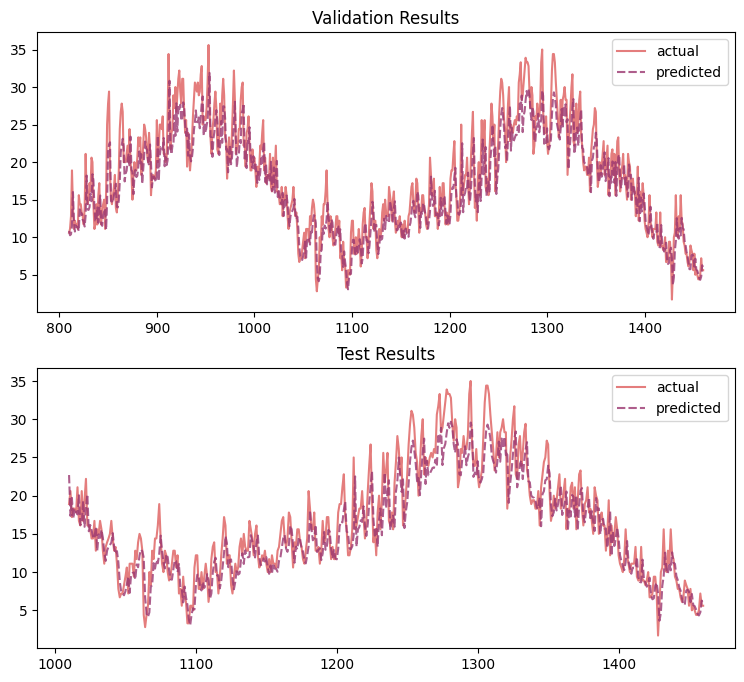

In [15]:
pred = np.concatenate([train_pred, val_pred, test_pred])
df_pred = pd.DataFrame(df["temp_max"].copy())
df_pred.columns = ["actual"]
df_pred = df_pred[WINDOW:]
df_pred["predicted"] = pred

fig, axes = plt.subplots(2, 1, figsize=(9, 8))
plt.subplot(2, 1, 1)
plt.title("Validation Results")
sns.lineplot(df_pred[800:], alpha=0.8, palette="flare", linestyle=None)

plt.subplot(2, 1, 2)
plt.title("Test Results")
sns.lineplot(df_pred[1000:], alpha=0.8, palette="flare", linestyle=None)

In [16]:
r2_test = r2_score(y_test, test_pred)
print(f"R2 Score on Test Data: {r2_test:.4f}")

R2 Score on Test Data: 0.8357


In [17]:
num_future_days = 20
initial_sequence = test_pred[-WINDOW:]

predicted_temperatures = []

for day in range(num_future_days):
    input_sequence = initial_sequence[-WINDOW:].reshape(1, WINDOW, 1)
    next_day_prediction = model.predict(input_sequence)[0, 0]
    predicted_temperatures.append(next_day_prediction)

    initial_sequence = np.append(initial_sequence, next_day_prediction)
    initial_sequence = initial_sequence[1:]

1/1 [==============================] - 0s 32ms/step


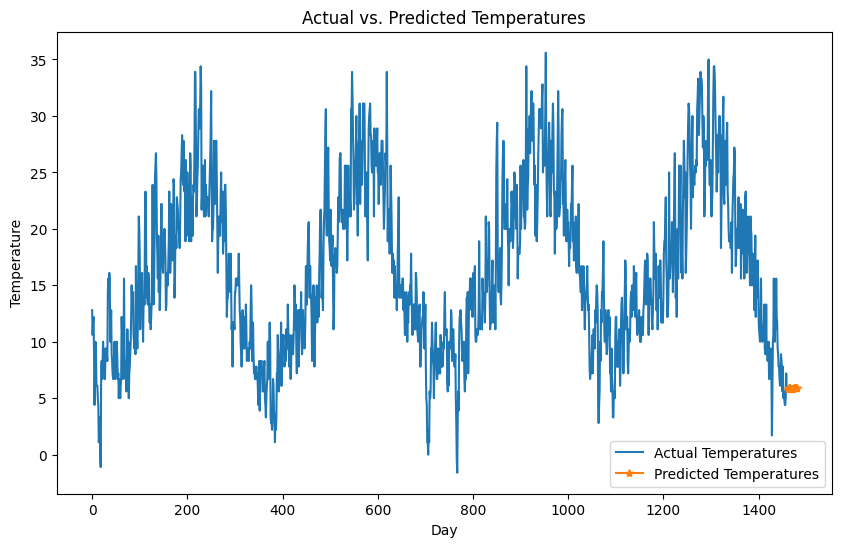

In [18]:
plt.figure(figsize=(10, 6))
plt.plot(df_tempmax1, label='Actual Temperatures')
plt.plot(np.arange(len(df_tempmax1), len(df_tempmax1) + num_future_days),
         predicted_temperatures, label='Predicted Temperatures', marker='*')
plt.xlabel('Day')
plt.ylabel('Temperature')
plt.title('Actual vs. Predicted Temperatures')
plt.legend()
plt.show()